---
title: "Bayesian Analysis with Python (3ed) Exercises"
format:
  html:
    code-fold: true
    code-tools: true
jupyter: python3
---

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pymc as pm
import preliz as pz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import os
n_devices = 128
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count={}".format(n_devices)
os.environ['JAX_PLATFORMS'] = 'cpu'  # BlackJAX NUTS sampler seems to have issues with JAX METAL on Apple M2
import jax
import jax.numpy as jnp

In [3]:
# See discussion at https://blackjax-devs.github.io/blackjax/examples/howto_sample_multiple_chains.html#choosing-the-number-of-devices
# Referenced github issue thread suggests that setting the device count to > actual number of cores may give unexpected behaviour but
# a few people in the thread saying it is useful for MCMC so give it a try
def fn(x):
    return x + 1

try:
    data = jnp.arange(128)
    parallel_fn = jax.pmap(fn)
    parallel_fn(data)
    # print(data)
except Exception as e:
    # Will fail if the number of devices has been set to < n_devices
    print(e)


Bayesian Data Analysis with Python Chapter 2 example

In [4]:
trials = 4
theta_real = 0.35
data = pz.Bernoulli(p=theta_real).rvs(trials, random_state=123)
print(np.mean(data))

0.25


In [5]:
chains = jax.local_device_count('cpu')
print(f'Number of chains: {chains}')

Number of chains: 128


In [6]:
with pm.Model() as our_first_model_model:
    theta = pm.Beta('theta', alpha=1., beta=1.)
    y = pm.Bernoulli('y', p=theta, observed=data)
    idata = pm.sample(1000, nuts_sampler='blackjax', progressbar=False, chains=chains)

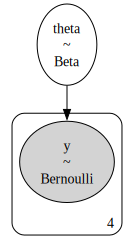

In [7]:
pm.model_to_graphviz(our_first_model_model)

array([[<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

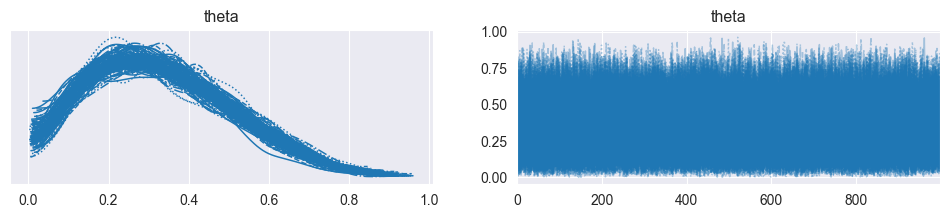

In [8]:
az.plot_trace(idata)

In [9]:
# Try BetaBinomial using the sum of trials i.e. just fit the summary statistic
with pm.Model() as our_second_model_model:
    theta = pm.Beta('theta', alpha=1., beta=1.)
    y = pm.Binomial('y', n=trials, p=theta, observed=np.sum(data))
    idata = pm.sample(1000, nuts_sampler='blackjax', progressbar=False, chains=chains)

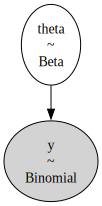

In [10]:
pm.model_to_graphviz(our_second_model_model)

In [11]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

array([[<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

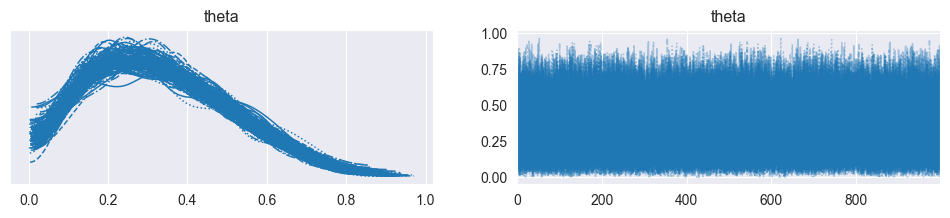

In [12]:
az.plot_trace(idata)

array([[<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

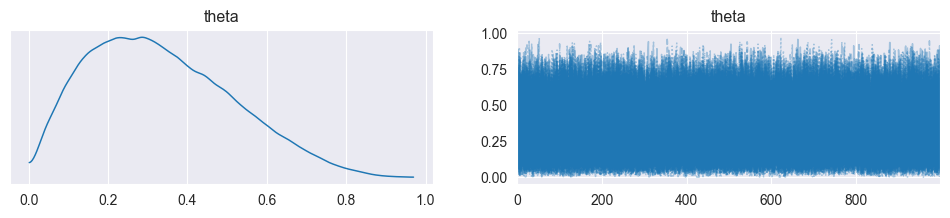

In [13]:
# kind='rank_bars' to show how uniform each trace is i.e. if it is exploring the full distribution
# Using JAX as the sampler lets us use chains >> number of CPU cores so rank bars plot gets a bit busy and hard to interpret
az.plot_trace(idata, kind='trace', combined=True)

In [14]:
az.summary(idata, kind='stats')

,mean,sd,hdi_3%,hdi_97%
theta,0.334,0.179,0.032,0.66


<Axes: title={'center': 'theta'}>

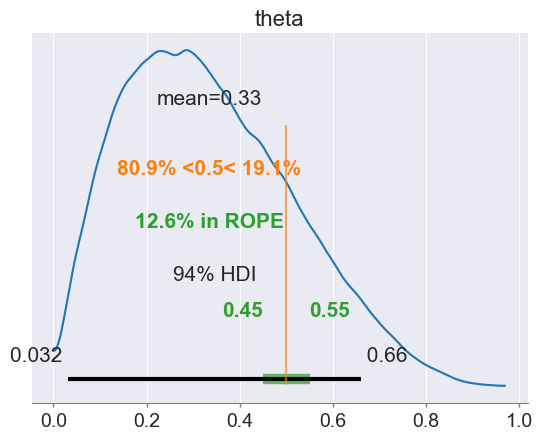

In [15]:
az.plot_posterior(idata, rope=[0.45, 0.55], ref_val=0.5)

({'BF10': 0.7283620242715129, 'BF01': 1.3729436278616691},
 <Axes: title={'center': 'The BF_10 is 0.73\nThe BF_01 is 1.37'}, xlabel='theta', ylabel='Density'>)

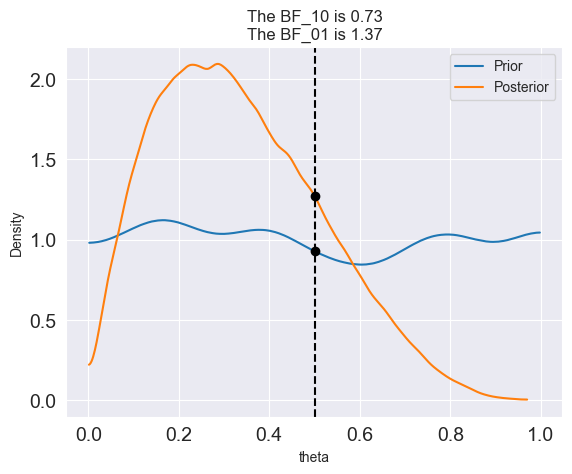

In [16]:
az.plot_bf(idata, var_name='theta', prior=pz.Beta(1, 1).rvs(1000), ref_val=0.5)

In [17]:
# Find theta that minimizes the loss function of the posterior
theta_pos = idata.posterior['theta']

Text(0.5, 1.0, 'Min l1 loss $\\theta$=0.31  Min l2 loss $\\theta$=0.33')

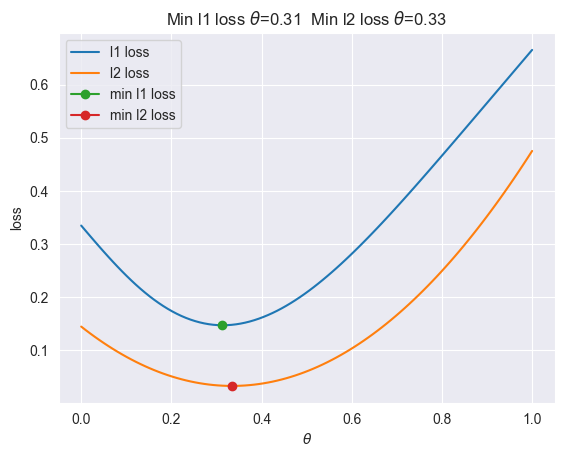

In [18]:
theta_test = jnp.linspace(0, 1, 100)
l1_norm = jax.vmap(lambda x: jnp.mean(jnp.abs(x - theta_pos.values)))(theta_test)
l2_norm = jax.vmap(lambda x: jnp.mean((x - theta_pos.values)**2))(theta_test)
min_l1_norm_ind = jnp.argmin(l1_norm)
min_l2_norm_ind = jnp.argmin(l2_norm)
plt.plot(theta_test, l1_norm, label='l1 loss')
plt.plot(theta_test, l2_norm, label='l2 loss')
plt.plot(theta_test[min_l1_norm_ind], l1_norm[min_l1_norm_ind], label='min l1 loss', marker='o')
plt.plot(theta_test[min_l2_norm_ind], l2_norm[min_l2_norm_ind], label='min l2 loss', marker='o')
plt.legend()
plt.xlabel(r'$\theta$')
plt.ylabel('loss')
plt.title(rf'Min l1 loss $\theta$={theta_test[min_l1_norm_ind]:0.2f}  Min l2 loss $\theta$={theta_test[min_l2_norm_ind]:0.2f}')

In [19]:
# Or just take median, mean of posterior :)
print(rf'theta = {np.median(theta_pos.values):0.2f} median, {np.mean(theta_pos.values):0.2f} mean')

theta = 0.31 median, 0.33 mean


# Tips Dataset
Chapter 2 section on comparing groups by having a vector of means and standard deviations for tips dependent on day of week.
Extend the book example by some feature engineering to look at top rate i.e. tip / total_bill
Chapter 3 moves on to discussing hierarchical models, one thing to check is whether these handle small sub-groups well as this is
an area where the curse of dimensionality usually arises.

In [20]:
df_tips_raw = pd.read_csv('https://raw.githubusercontent.com/aloctavodia/BAP3/refs/heads/main/code/data/tips.csv')

In [21]:
df_tips_raw['size'].value_counts()

size
2    156
3     38
4     37
5      5
1      4
6      4
Name: count, dtype: int64

In [74]:
df_tips = df_tips_raw.assign(
    tip_rate=lambda x: x.tip/x.total_bill,
    tip_rate_logit=lambda x: np.log(x.tip_rate/(1-x.tip_rate)),
    per_person_bill=lambda x: x.total_bill/x['size'],  # NB: not x.size as this calls the ndarray method
    day_idx=lambda x: pd.Categorical(x.day, ['Thur', 'Fri', 'Sat', 'Sun']).codes
)

In [76]:
df_tips.tip_rate.describe()

count    244.000000
mean       0.160803
std        0.061072
min        0.035638
25%        0.129127
50%        0.154770
75%        0.191475
max        0.710345
Name: tip_rate, dtype: float64

The expected masses are 0.25, 0.5, 0.75
 The computed ones are: 0.26, 0.48, 0.76


(Beta(alpha=10, beta=52.6), <Axes: >)

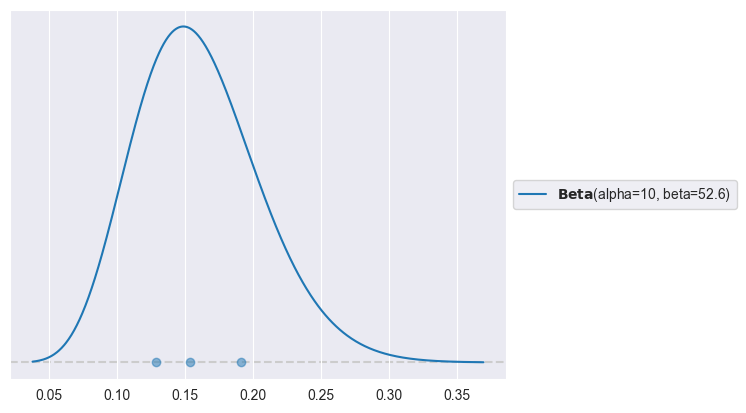

In [73]:
tip_rate_dist = pz.Beta()
# pz.maxent(tip_rate_dist, 0.12, 0.19, 0.5)
pz.quartile(tip_rate_dist, 0.129, 0.154, 0.191)

In [77]:
df_tips.tip_rate_logit.describe()

count    244.000000
mean      -1.708967
std        0.428149
min       -3.298050
25%       -1.908704
50%       -1.697674
75%       -1.440454
max        0.897059
Name: tip_rate_logit, dtype: float64

The expected masses are 0.25, 0.5, 0.75
 The computed ones are: 0.26, 0.49, 0.76


(Normal(mu=-1.68, sigma=0.348), <Axes: >)

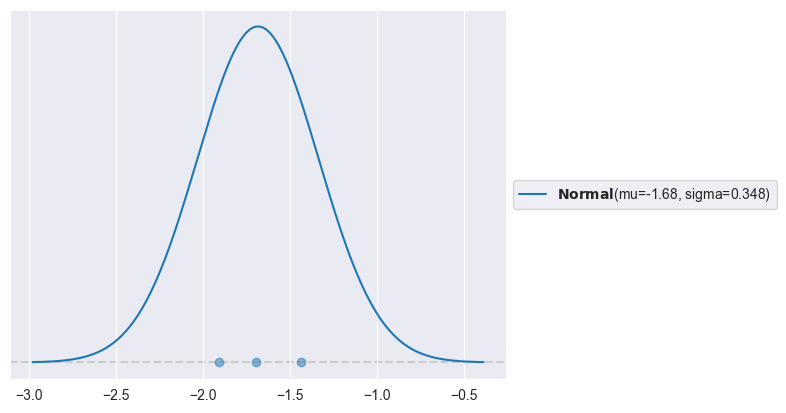

In [78]:
tip_rate_logit_dist = pz.Normal()
pz.quartile(tip_rate_logit_dist, -1.908, -1.697, -1.440)

In [79]:
# Use PyCharm column statistics
df_tips

,total_bill,tip,sex,smoker,day,time,size,tip_rate,tip_rate_logit,per_person_bill,day_idx
0,16.99,1.01,Female,No,Sun,Dinner,2,0.059447,-2.761388,8.495000,3
1,10.34,1.66,Male,No,Sun,Dinner,3,0.160542,-1.654204,3.446667,3
2,21.01,3.50,Male,No,Sun,Dinner,3,0.166587,-1.610009,7.003333,3
3,23.68,3.31,Male,No,Sun,Dinner,2,0.139780,-1.817115,11.840000,3
4,24.59,3.61,Female,No,Sun,Dinner,4,0.146808,-1.759862,6.147500,3
...,...,...,...,...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3,0.203927,-1.361929,9.676667,2
240,27.18,2.00,Female,Yes,Sat,Dinner,2,0.073584,-2.532903,13.590000,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2,0.088222,-2.335536,11.335000,2
242,17.82,1.75,Male,No,Sat,Dinner,2,0.098204,-2.217338,8.910000,2


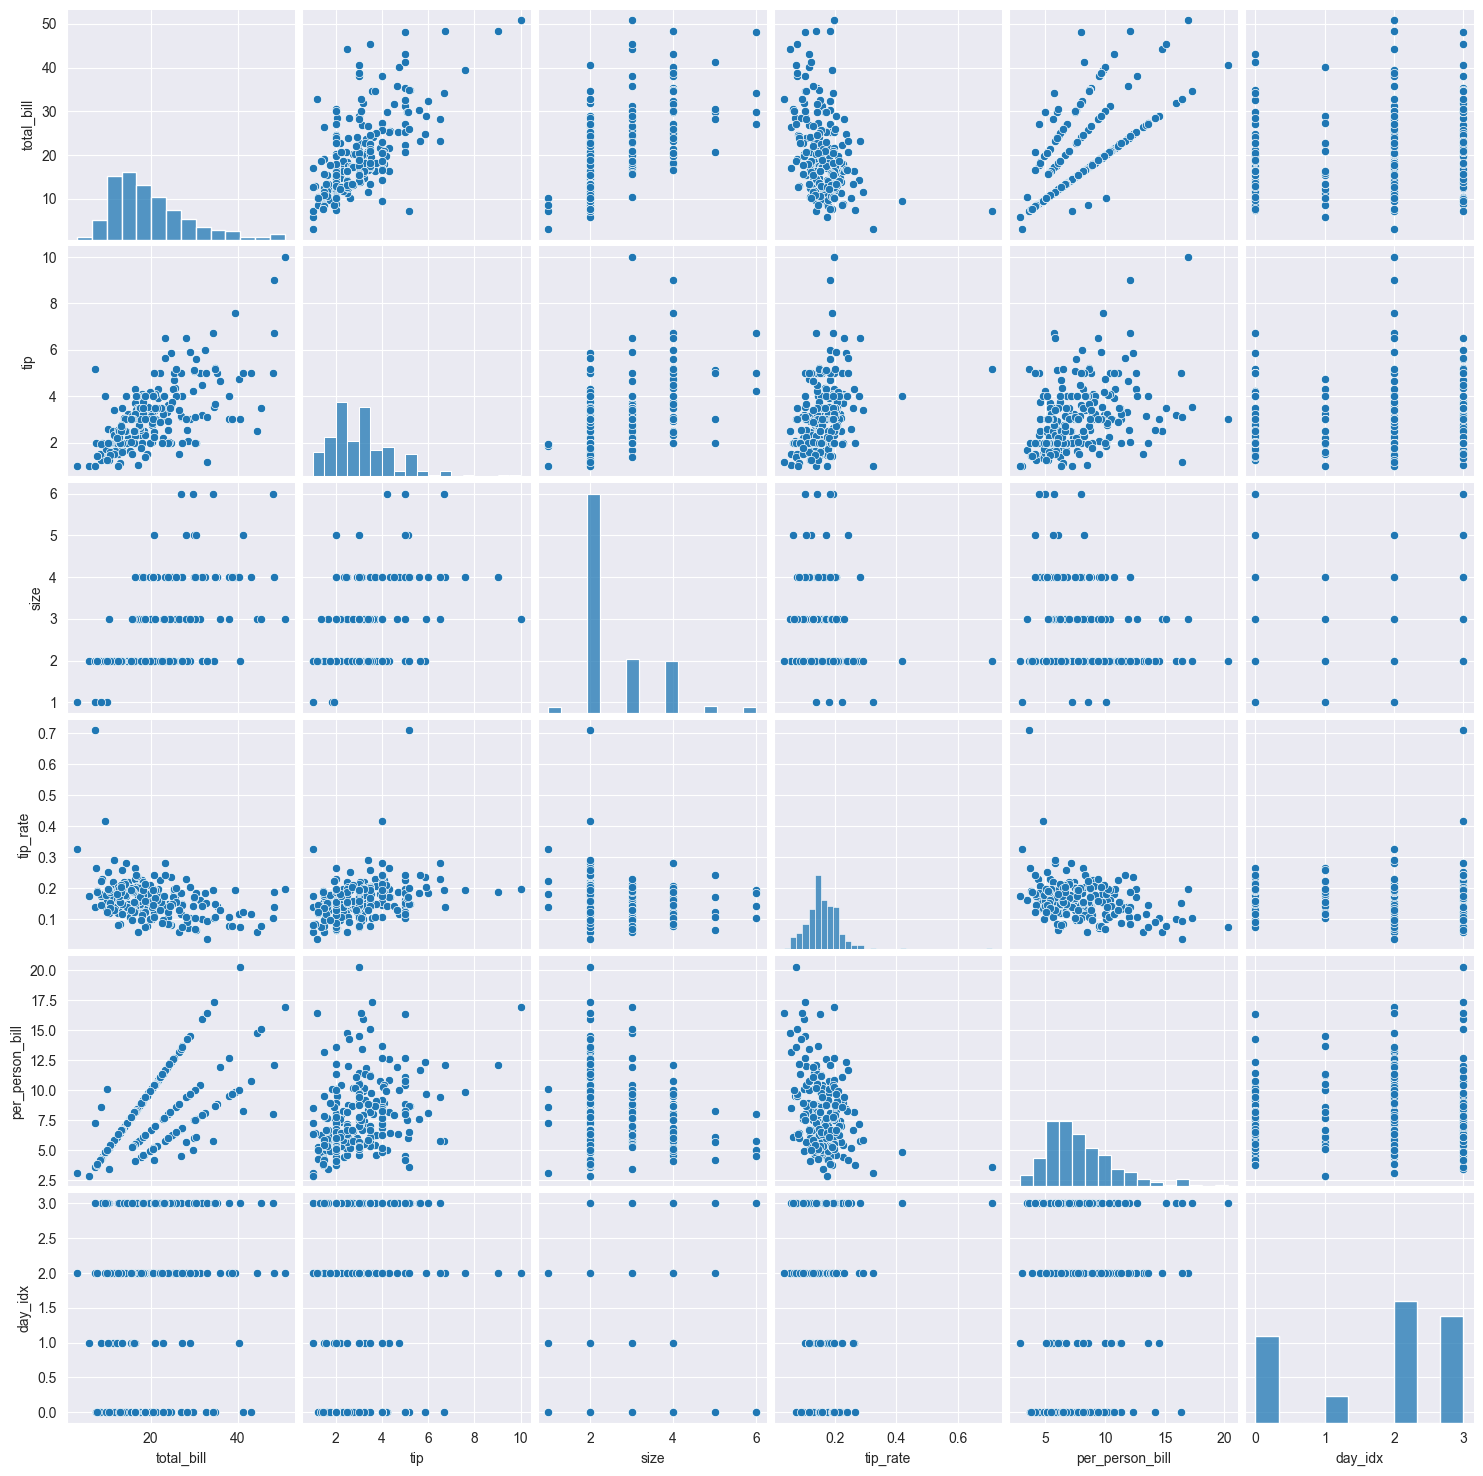

In [24]:
sns.pairplot(df_tips)

In [25]:
# sns.clustermap(pd.get_dummies(df_tips, drop_first=True).corr(), annot=True, cmap='viridis')

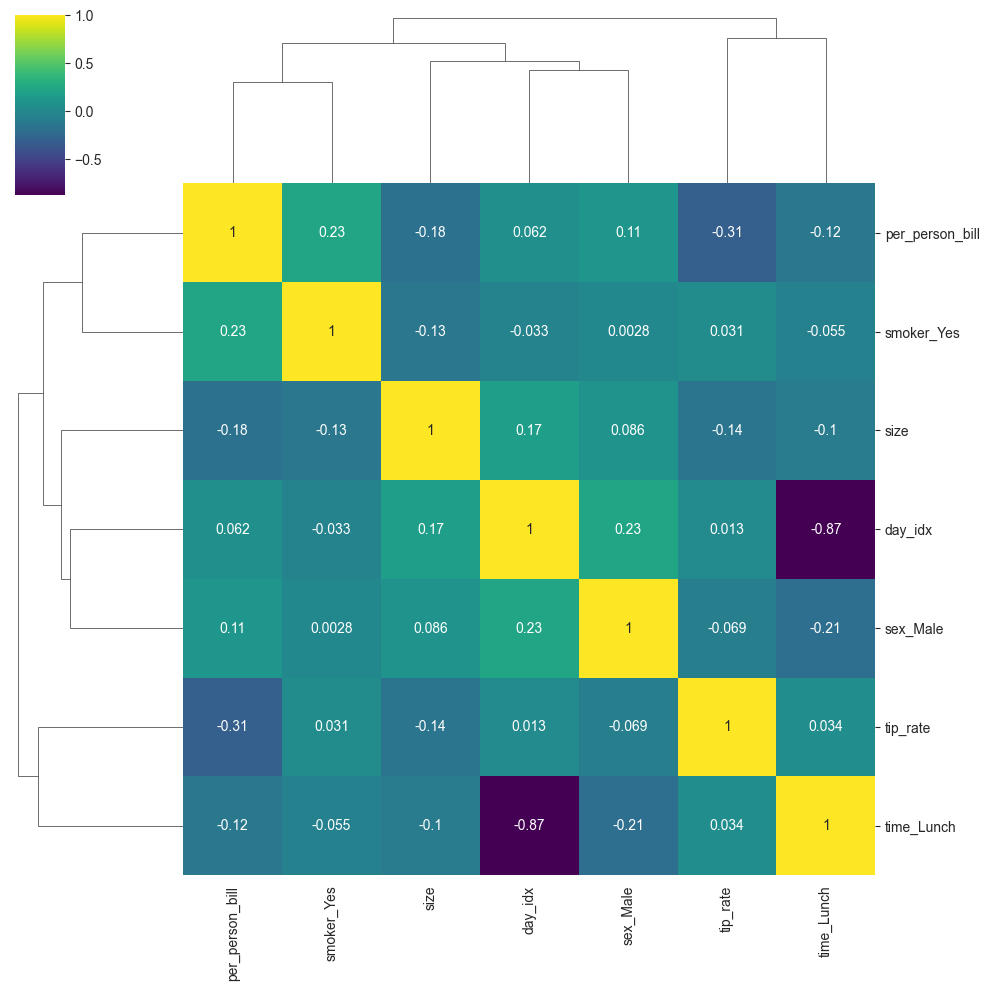

In [26]:
sns.clustermap(
    pd.get_dummies(
        df_tips.drop(columns=['tip', 'total_bill', 'day'])
        , drop_first=True
).corr(), annot=True, cmap='viridis')


In [31]:
with pm.Model() as tip_day_model:
    # Model tip amount by day group
    mu = pm.HalfNormal('mu', sigma=5., shape=4)
    sigma = pm.HalfNormal('sigma', sigma=1., shape=4)
    y = pm.Gamma('y', mu=mu[df_tips.day_idx], sigma=sigma[df_tips.day_idx], observed=df_tips.tip)

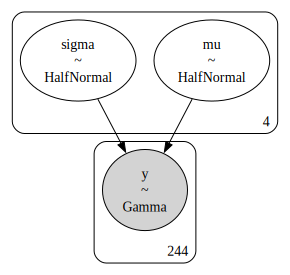

In [32]:
pm.model_to_graphviz(tip_day_model)

In [33]:
with tip_day_model:
    idata = pm.sample(1000, nuts_sampler='blackjax', progressbar=False, chains=chains)

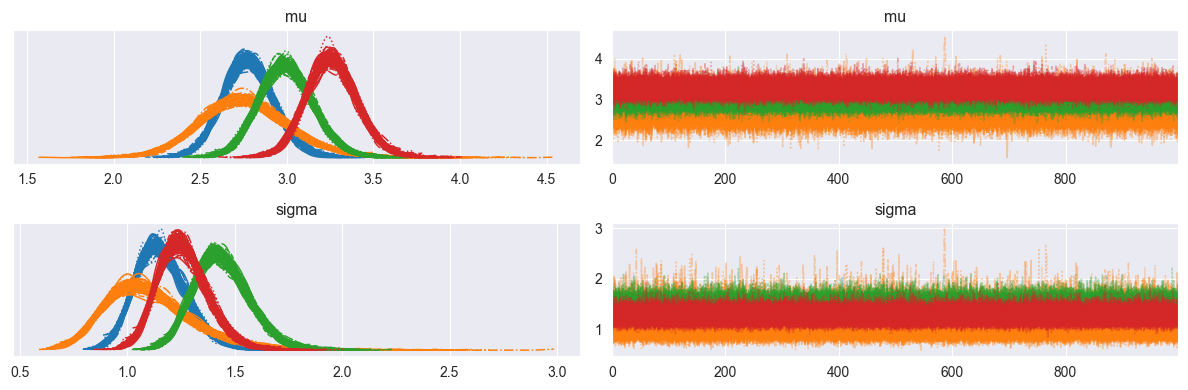

In [34]:
az.plot_trace(idata)
plt.tight_layout()

In [36]:
# Alternative syntax
categories = np.array(['Thur', 'Fri', 'Sat', 'Sun'])
idx = df_tips.day_idx
coords = {'days': categories, 'days_flat': categories[idx]}

In [38]:
with pm.Model(coords=coords) as comparing_groups:
    # Model tip amount by day group
    mu = pm.HalfNormal('mu', sigma=5., dims='days')
    sigma = pm.HalfNormal('sigma', sigma=1., dims='days')
    y = pm.Gamma('y', mu=mu[idx], sigma=sigma[idx], observed=df_tips.tip, dims='days_flat')

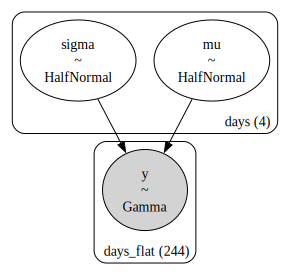

In [43]:
pm.model_to_graphviz(comparing_groups)

In [39]:
with comparing_groups:
    idata_cg = pm.sample(1000, nuts_sampler='blackjax', progressbar=False, chains=chains)
    idata_cg.extend(pm.sample_posterior_predictive(idata_cg))

Sampling: [y]


Output()

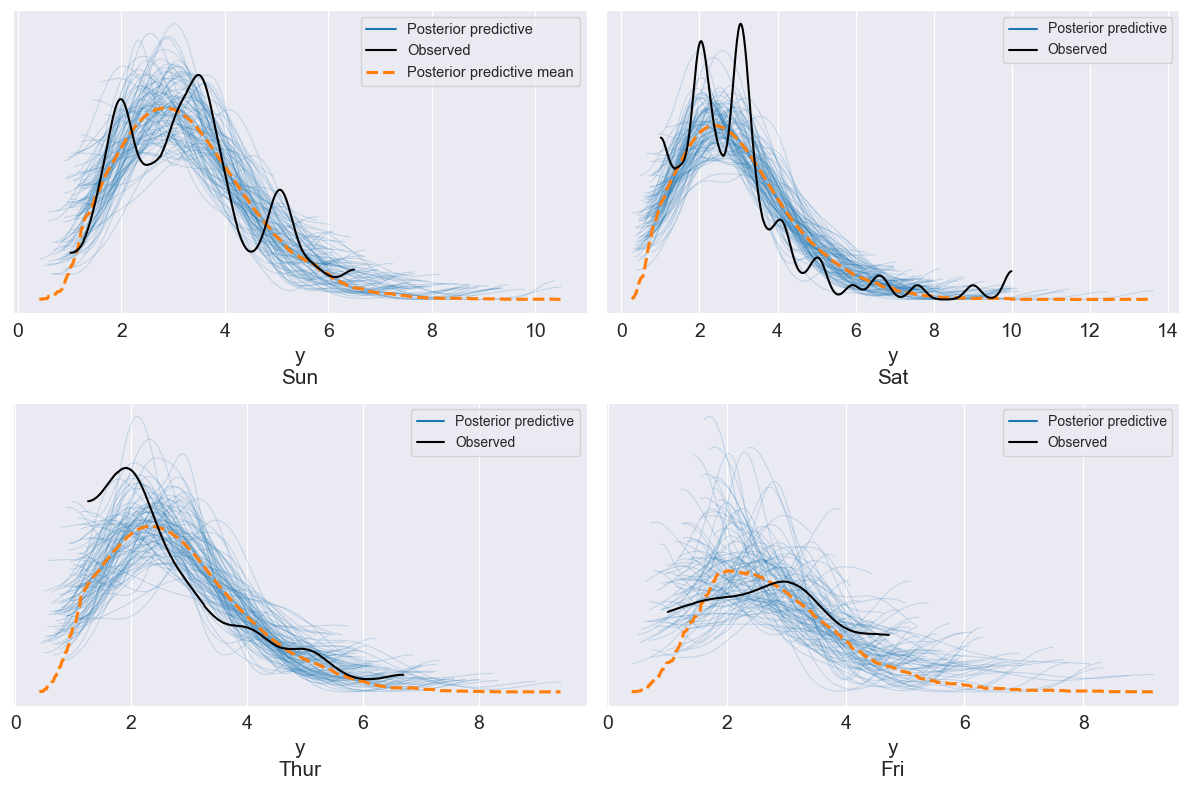

In [42]:
_, axs = plt.subplots(2, 2, figsize=(12, 8))
az.plot_ppc(
    idata_cg, num_pp_samples=100,
    coords={'days_flat': categories}, flatten=[], ax=axs
)
plt.tight_layout()

In [51]:
with pm.Model(coords=coords) as comparing_groups_rate:
    # Model tip_rate amount by day group
    mu = pm.HalfNormal('mu', sigma=5., dims='days')
    sigma = pm.HalfNormal('sigma', sigma=1., dims='days')
    y = pm.Gamma('y', mu=mu[idx], sigma=sigma[idx], observed=df_tips.tip_rate, dims='days_flat')

In [52]:
with comparing_groups_rate:
    idata_cgr = pm.sample(1000, nuts_sampler='blackjax', progressbar=False, chains=chains)
    idata_cgr.extend(pm.sample_posterior_predictive(idata_cgr))

Sampling: [y]


Output()

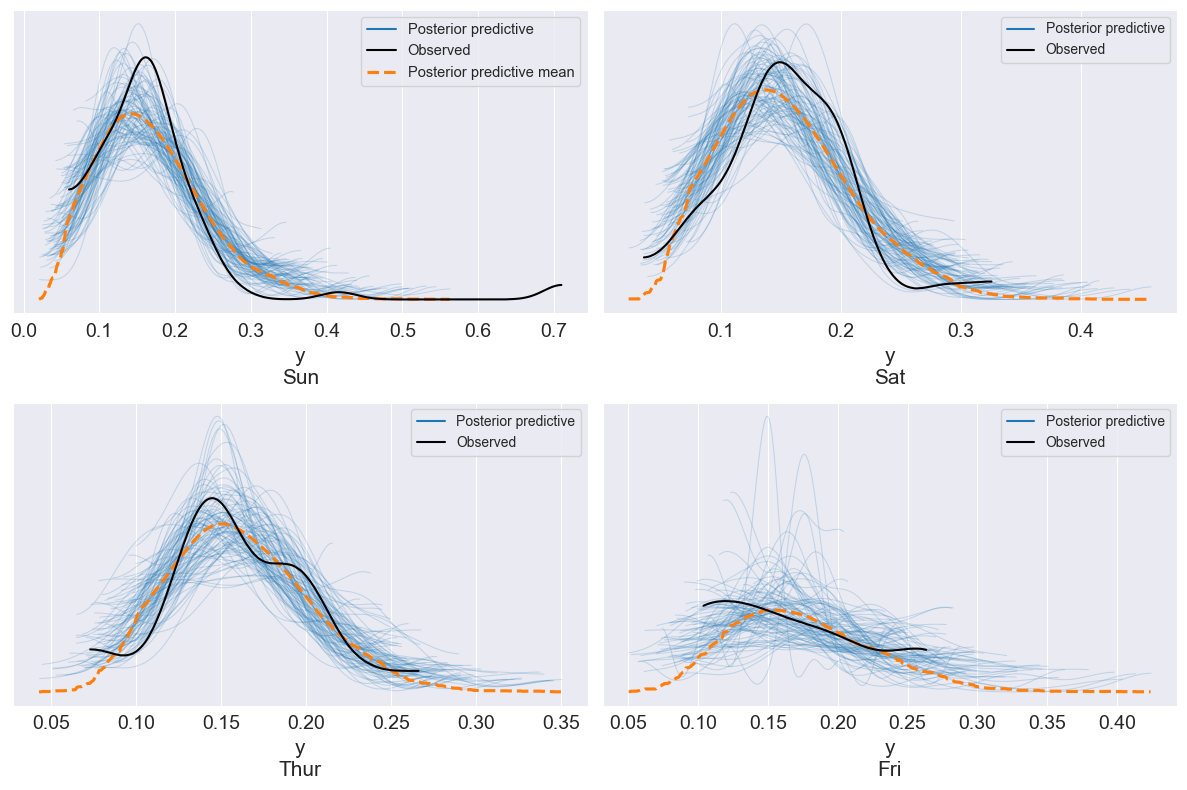

In [53]:
_, axs = plt.subplots(2, 2, figsize=(12, 8))
az.plot_ppc(
    idata_cgr, num_pp_samples=100,
    coords={'days_flat': categories}, flatten=[], ax=axs
)
plt.tight_layout()

Maybe beta distribution is a better fit for tip_rate

In [142]:
with pm.Model(coords=coords) as comparing_groups_rate_unobs:
    # Model tip_rate amount by day group
    mu = pm.Uniform('mu', 0.0, 1., dims='days')
    nu = pm.Uniform('nu', 10, 300, dims='days')
    # Beta distribution can accept a mu, sigma or nu (~ number of observations) parameterization
    y = pm.Beta('y', mu=mu[idx], nu=nu[idx], dims='days_flat')  # NB: try not specifiying obs here ...

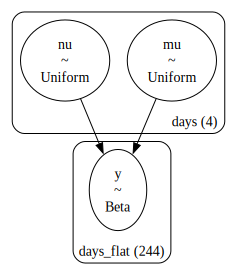

In [143]:
pm.model_to_graphviz(comparing_groups_rate_unobs)

In [144]:
# ... then create a new model by adding observations
comparing_groups_rate = pm.observe(comparing_groups_rate_unobs, {y: df_tips.tip_rate})

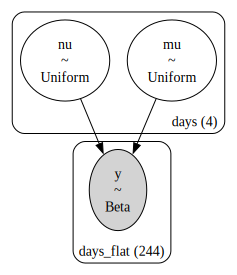

In [145]:
pm.model_to_graphviz(comparing_groups_rate)

In [146]:
with comparing_groups_rate:
    start = pm.find_MAP()

Output()

In [147]:
start

{'mu_interval__': array([-1.64900987, -1.58581165, -1.71098184, -1.58653982]),
 'nu_interval__': array([-0.99524443, -1.39651003, -1.96367968, -2.91799889]),
 'mu': array([0.16124281, 0.16997398, 0.15303641, 0.16987128]),
 'nu': array([88.26446029, 67.52744538, 45.69011832, 24.86857607])}

In [126]:
# Note that the MAP fit to nu is roughly the observation counts for the corresponding day
df_tips.day.value_counts()

day
Sat     87
Sun     76
Thur    62
Fri     19
Name: count, dtype: int64

In [153]:
# ... and the mu MAP values match the group means
df_tips.groupby('day').tip_rate.mean()[categories]

day
Thur    0.161276
Fri     0.169913
Sat     0.153152
Sun     0.166897
Name: tip_rate, dtype: float64

In [148]:
with comparing_groups_rate:
    idata_cgr = pm.sample(1000, nuts_sampler='blackjax', progressbar=False, chains=chains, initvals=start)
    idata_cgr.extend(pm.sample_posterior_predictive(idata_cgr))

Sampling: [y]


Output()

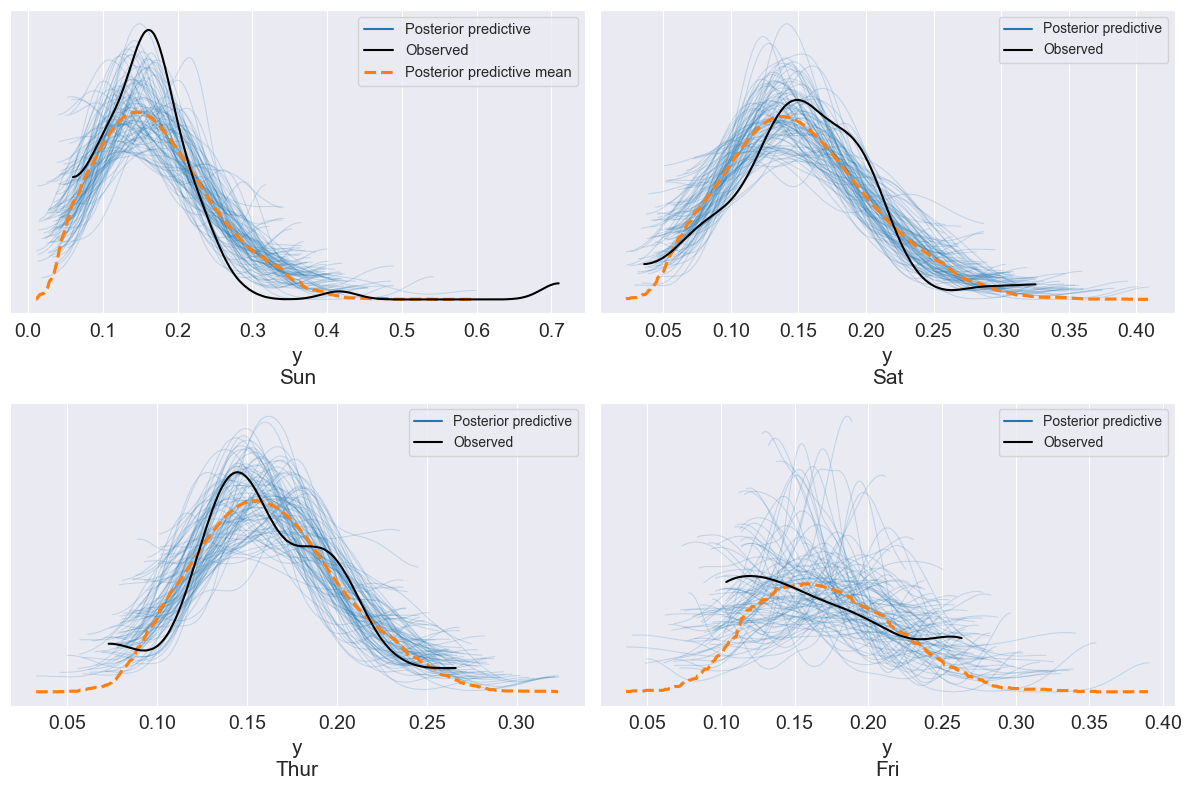

In [149]:
_, axs = plt.subplots(2, 2, figsize=(12, 8))
az.plot_ppc(
    idata_cgr, num_pp_samples=100,
    coords={'days_flat': categories}, flatten=[], ax=axs
)
plt.tight_layout()

array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'nu'}>, <Axes: title={'center': 'nu'}>]],
      dtype=object)

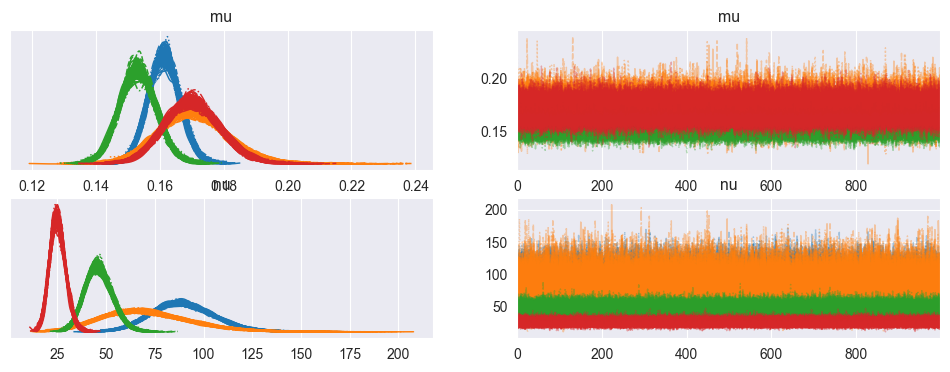

In [150]:
az.plot_trace(idata_cgr)

Hierarchical version - similar to the soccer player example in Chapter 3

In [172]:
with pm.Model(coords=coords) as comparing_groups_rate_hier:
    # Global priors
    mu_g = pm.Beta('mu_g', alpha=1, beta=1)
    nu_g = pm.Gamma('nu_g', mu=125, sigma=50)  # Arbitrary choice copied from Code 3.5 example
    # Model tip_rate amount by day group
    mu = pm.Beta('mu', mu=mu_g, nu=nu_g, dims='days')
    nu = pm.Gamma('nu', mu=125, sigma=50, dims='days')
    y = pm.Beta('y', mu=mu[idx], nu=nu[idx], observed=df_tips.tip_rate, dims='days_flat')

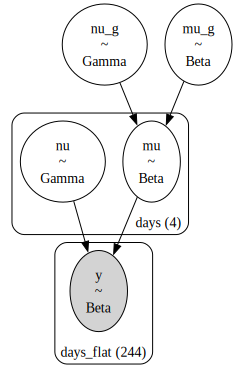

In [173]:
pm.model_to_graphviz(comparing_groups_rate_hier)

In [174]:
with comparing_groups_rate_hier:
    start = pm.find_MAP()

Output()

In [175]:
start

{'mu_g_logodds__': array(-1.62217236),
 'nu_g_log__': array(4.96548421),
 'mu_logodds__': array([-1.64984033, -1.5958179 , -1.71264742, -1.59880929]),
 'nu_log__': array([4.5035233 , 4.35024306, 3.88310028, 3.31196305]),
 'mu_g': array(0.16490549),
 'nu_g': array(143.37795811),
 'mu': array([0.16113053, 0.16856693, 0.15282065, 0.1681481 ]),
 'nu': array([90.33484774, 77.49729711, 48.57457656, 27.43893669])}

In [176]:
with comparing_groups_rate_hier:
    idata_cgrh = pm.sample(1000, nuts_sampler='blackjax', progressbar=False, chains=chains, initvals=start)
    idata_cgrh.extend(pm.sample_posterior_predictive(idata_cgrh))

Sampling: [y]


Output()

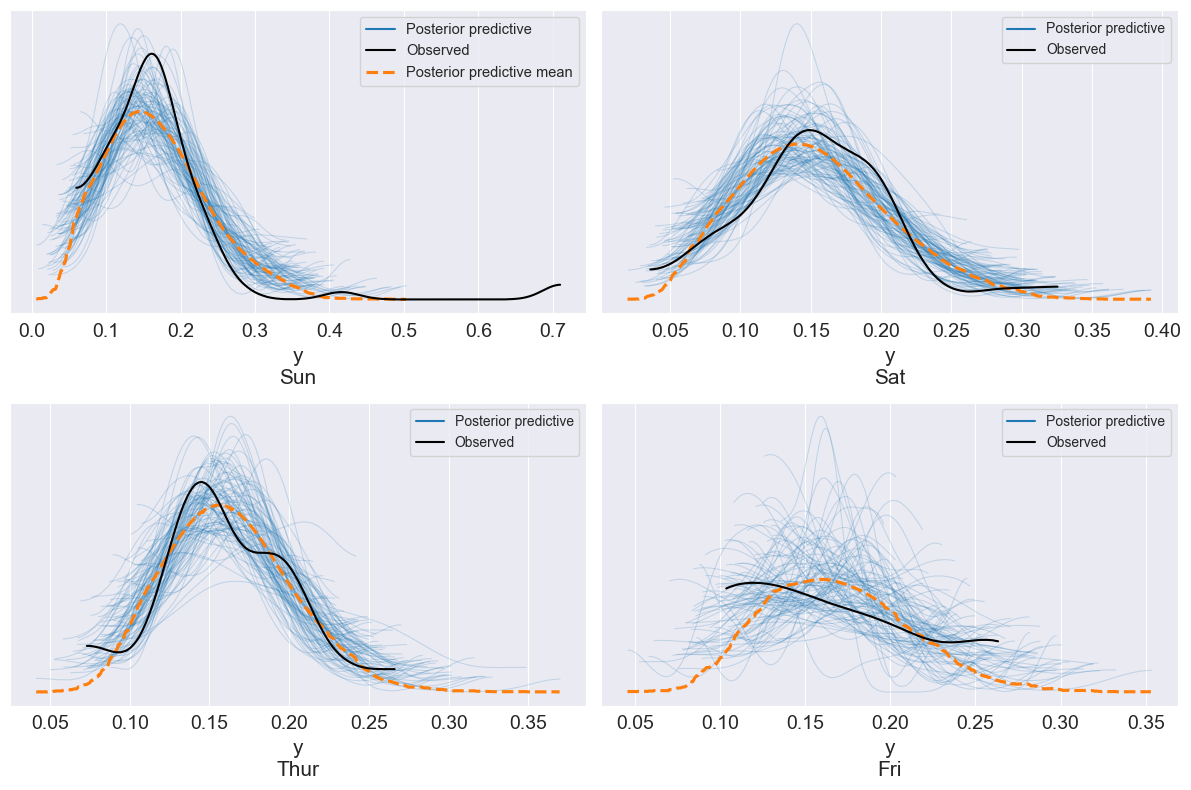

In [177]:
_, axs = plt.subplots(2, 2, figsize=(12, 8))
az.plot_ppc(
    idata_cgrh, num_pp_samples=100,
    coords={'days_flat': categories}, flatten=[], ax=axs
)
plt.tight_layout()

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

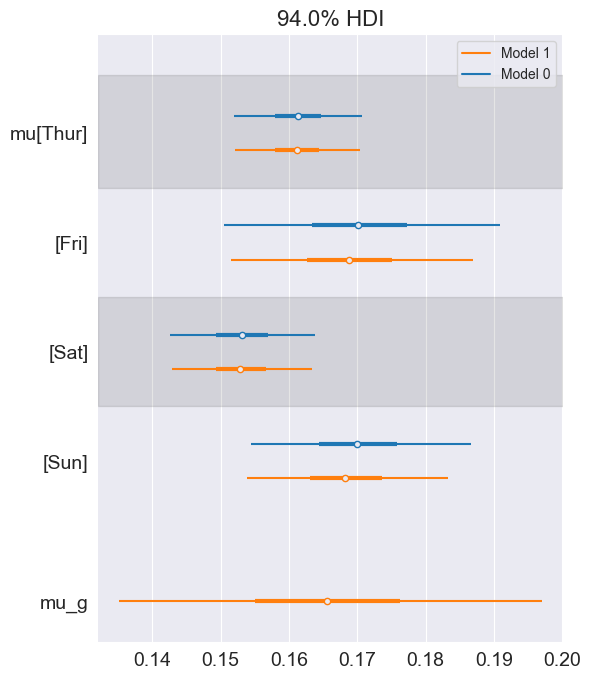

In [179]:
# We see the hierachical model (model 1) has pulled the mu estimates closer to the global
az.plot_forest([idata_cgr, idata_cgrh], combined=True, var_names=['mu', 'mu_g'])

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

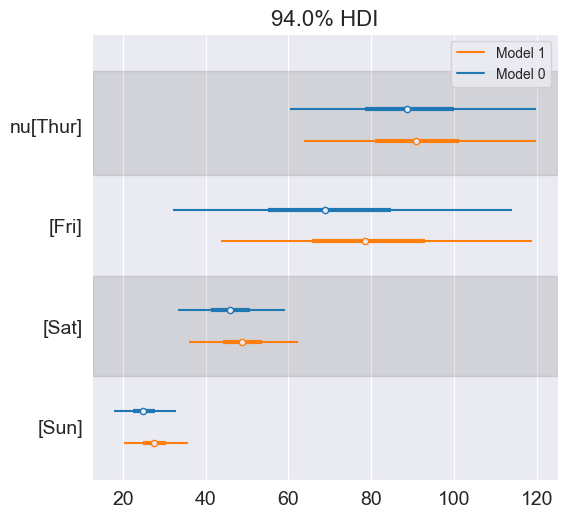

In [180]:
# Realised after plotting that the two models use different distributions for nu (Uniform vs Gamma) but the
# posterior distributions look similar
az.plot_forest([idata_cgr, idata_cgrh], combined=True, var_names=['nu'])